# The Arena
### Pitting contenders against each other

In [1]:
from tqdm import tqdm
from domoku.policies.softadvice import MaxInfluencePolicyParams, MaxInfluencePolicy
from domoku.policies.maximal_criticality import MaxCriticalityPolicy
from domoku.policies import softadvice
from alphazero.gomoku_game import GomokuGame as Game
from alphazero.mcts import MCTS
from alphazero.gomoku_board import *

In [2]:
BOARD_SIZE=15

In [3]:
from domoku.policies.threat_search import ThreatSearchPolicy


def given_heuristic_brain():
    threat_model = ThreatSearchPolicy(board_size=BOARD_SIZE)
    hard_policy = MaxCriticalityPolicy(board_size=BOARD_SIZE)
    mi_params = MaxInfluencePolicyParams(
        board_size=BOARD_SIZE,
        sigma=.4,
        iota=20,
        radial_constr=[.0625, .125, .25, .5],
        radial_obstr=[-.0625, -.125, -.25, -.5]
    )
    policy = MaxInfluencePolicy(mi_params, criticality_model=hard_policy, threat_model=threat_model, pov=1)
    return softadvice.NeuralNetAdapter(policy)


def longest_trajectory(ts):
    depths = [v.level for v in ts.tree_nodes.values()]
    mx = max(depths)
    return [v for v in ts.tree_nodes.values() if v.level == mx][0]

---
# Current Status


- Still, with num_simus = 400, the play does not appear to be future-looking, need clarification (alphago uses 1600)
- update_tree_view does not (always) work with two distinct mcts instances, since the parent lives in another tree.
- The state values displayed are always negative. Needs to be verified
- It's not clear how the mcts actually chooses the next move. We need to understand, what a good value for cpuct should be. It's the $u$ value:

$$
U(s, a) = Q(s, a) + c_{puct} P(s, a) \frac{\sqrt{\sum_b N(s, b)}}{1 + N(s, a)}
$$

---
### The initial board

In [6]:
readable = "C11F9E9G8F7G7G9H8I8H7I6I9F6H6H9I5J4"

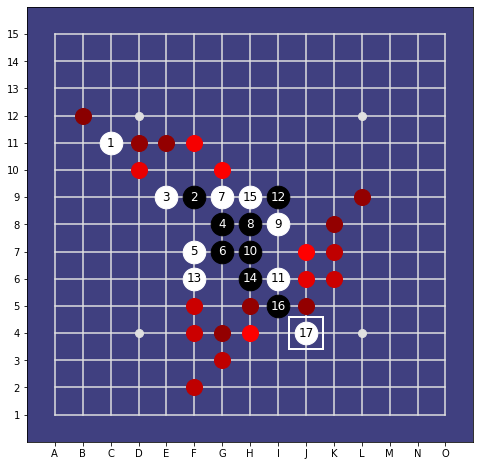

In [7]:
from domoku.tools import GomokuTools as Gt
from domoku.board import GomokuBoard as LegacyBoard

threat_model = ThreatSearchPolicy(board_size=BOARD_SIZE)
stones = Gt.string_to_stones(readable)
board_t = LegacyBoard(n=BOARD_SIZE, disp_width=8, stones=stones, heuristics=threat_model)
board_t.display()

In [8]:
detector = MaxCriticalityPolicy(BOARD_SIZE)
the_game = Game(BOARD_SIZE, detector=detector, initial=readable)

brain_d = given_heuristic_brain()
mcts_d = MCTS(the_game, brain_d, cpuct=1.0, num_simulations=900, model_threshold=.3)

brain_c = given_heuristic_brain()
mcts_c = MCTS(the_game, brain_c, cpuct=1.0, num_simulations=900, model_threshold=.4)

board = the_game.get_initial_board()
key = board.get_string_representation()
print(key)
Move=board.Stone

-8198937255357338458


In [9]:
res = brain_d.policy(board.math_rep, verbose=1, stone=board.Stone)
probs = mcts_d.get_action_prob(board, temperature=0)
move = Move(probs)
print(f"White: {move}")
board.plot()

Critical:  B12 - 1.0, w=0.5
Threats:   J7 - 1.9996, w=1.0
Influence: E7 - 5.0591, w=0.1
Total:     G10 - 2.7663
White: F11
                                                     
15    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
14    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
13    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
12    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
11    .  .  X  .  .  .  .  .  .  .  .  .  .  .  .    
10    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 9    .  .  .  .  X  O  X  X  O  .  .  .  .  .  .    
 8    .  .  .  .  .  .  O  O  X  .  .  .  .  .  .    
 7    .  .  .  .  .  X  O  O  .  .  .  .  .  .  .    
 6    .  .  .  .  .  X  .  O  X  .  .  .  .  .  .    
 5    .  .  .  .  .  .  .  .  O  .  .  .  .  .  .    
 4    .  .  .  .  .  .  .  .  . [X] .  .  .  .  .    
 3    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 2    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 1    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
             

In [10]:
children = [(str(key), a) for a in mcts_d.probable_actions(board)]
{Move(int(c[1])): (mcts_d.Nsa.get(c), mcts_d.Q.get(c)) for c in children}

{B12: (41, -0.04778632380795188),
 D11: (1, -0.931041955947876),
 E11: (59, -0.023048890912431782),
 F11: (82, -0.03020348370347808),
 D10: (72, -0.037528465398483805),
 G10: (43, -0.06979341337154078),
 L9: (47, -0.02107196027769688),
 K8: (62, -0.03170282408715256),
 J7: (34, -0.07468279489480398),
 K7: (35, -0.03975205607712269),
 J6: (52, -0.04204641837769976),
 K6: (37, -0.065986846749847),
 F5: (71, -0.03243010228788349),
 H5: (1, -0.9338394403457642),
 J5: (51, -0.021153463890739514),
 F4: (40, -0.04213250153698027),
 G4: (53, -0.03171946607389539),
 H4: (1, -0.9338710308074951),
 G3: (62, -0.0357087986063092),
 F2: (55, -0.033318857103586196)}

In [ ]:
board.act(move)
board.plot()

In [11]:
board.print_pi(brain_d.policy)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  22  32  41  25  16   8   0   0   1   0   0   0   0]
 [  0 492  38  91  96  76  56  17   0  12   9  14   0   0   0]
 [  0  35   0 620 483 998  80  43   7  18 223  12  11   0   0]
 [  0  67 118 976 149 136 999  42  11  55  28  33   0   0   0]
 [  0  46 131 162   0   0   0   0   0  20  50 333  11   0   0]
 [  0  48 108 170 157  97   0   0   0  47 339  22   0   0   0]
 [  0  25  91 146 182   0   0   0  41 968 496  11   2   0   0]
 [  0  18  58 132 157   0  25   0   0 616 746   8  14   0   0]
 [  0   0  39  73  84 746  38 353   0 365  33  44   0   0   0]
 [  0   0  12  22  42 692 324 916  24   0  56  12  13   0   0]
 [  0   0   0   2   0   5 466   3   6  35  15  11   0   0   0]
 [  0   0   0   0   0 463   0   0   4   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


In [ ]:
res = brain_d.policy(board.math_rep, verbose=1, stone=board.Stone);
probs = mcts_d.get_action_prob(board, temperature=0)
move =Move(probs)
print(f"Black: {move}")

#current_node = mcts_d.tree_nodes[board.get_string_representation()]
#for a, c in current_node.children.items():
#    print(Move(a), c.value, c.info[a]['u'])

The values are always negative, which is not really easy to understand

In [11]:
pi, _ = mcts_c.nnet.predict(board.canonical_representation())

In [12]:
print((pi.reshape([15, 15])*100).astype(int))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 2 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 3 3 2 1 0 0 0]
 [0 0 0 0 0 0 2 3 3 3 2 1 0 0 0]
 [0 0 0 0 0 2 2 3 3 3 2 1 0 0 0]
 [0 0 0 0 0 1 2 2 0 2 2 1 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [13]:
mcts_c.tree_nodes[board.get_string_representation()]

KeyError: '-2734968144196659472'

In [ ]:
board.print_pi()

In [64]:
from domoku.tools import GomokuTools as Gt
stones = Gt.string_to_stones("".join([str(s) for s in board.stones]))

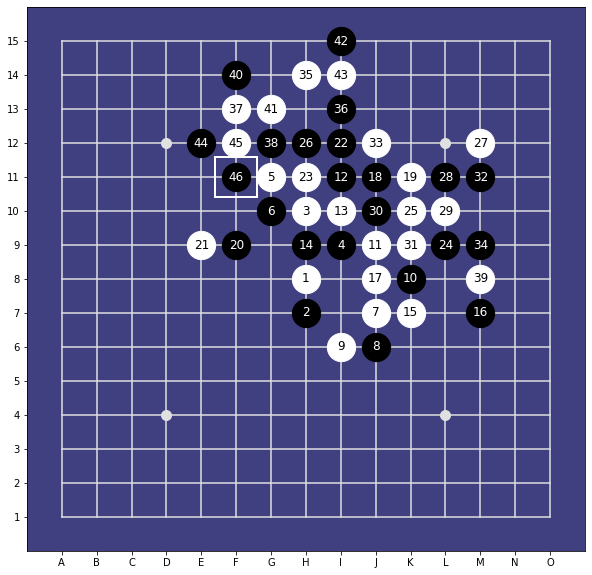

In [68]:
from domoku.board import GomokuBoard as LegacyBoard
legacy_board = LegacyBoard(n=15, disp_width=10, stones=stones)
legacy_board.display()

In [2]:
class Player:
    def __init__(self, mcts: MCTS, temperature):
        self.mcts = mcts
        self.temperature = temperature

    def play(self, board: Board):
       pass

In [3]:
class Arena:
    def __init__(self, game: Game):
        self.game = game
        pass

    def play_game(self, black: Player, white: Player, verbose: bool):
        pass

    def play_games(self, player1: Player, player2: Player, num_games, verbose=False):
        """
        Plays num games in which player1 starts num/2 games and player2 starts
        num/2 games.

        Returns:
            one_won: games won by player1
            two_won: games won by player2
            draws:  games won by nobody
        """

        num = int(num_games / 2)
        one_won = 0
        two_won = 0
        n_draws = 0
        for _ in tqdm(range(num), desc="Arena.play_games (1)"):
            game_result = self.play_game(black=player1, white=player2, verbose=verbose)
            if game_result == 1:
                one_won += 1
            elif game_result == -1:
                two_won += 1
            else:
                n_draws += 1

        for _ in tqdm(range(num), desc="Arena.play_games (2)"):
            game_result = self.play_game(black=player2, white=player1, verbose=verbose)
            if game_result == -1:
                one_won += 1
            elif game_result == 1:
                two_won += 1
            else:
                n_draws += 1

        return one_won, two_won, n_draws



In [ ]:
arena = Arena(the_game)

defender = Player(mcts_d, temperature=0)

challenger = Player(mcts_c, temperature=0)

defender_wins, challenger_wins, draws = arena.play_games(num_games=10, player1=defender, player2=challenger)

